## 5.1.3 期待ショートフォール

### 期待ショートフォール最小化問題

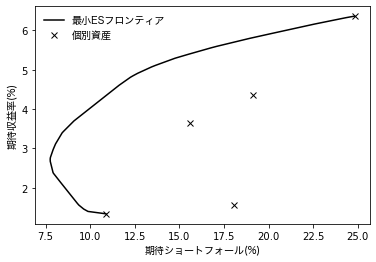

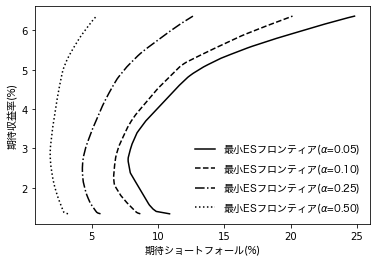

In [1]:
# -*- coding: utf-8 -*-
#%% NumPyの読み込み
import numpy as np
#   CVXPYの読み込み
import cvxpy as cvx
#   Pandasの読み込み
import pandas as pd
#   MatplotlibのPyplotモジュールの読み込み
import matplotlib.pyplot as plt
#   日本語フォントの設定
from matplotlib.font_manager import FontProperties
import sys
if sys.platform.startswith('win'):
    FontPath = 'C:\\Windows\\Fonts\\meiryo.ttc'
elif sys.platform.startswith('darwin'):
    FontPath = '/System/Library/Fonts/ヒラギノ角ゴシック W4.ttc'
elif sys.platform.startswith('linux'):
    FontPath = '/usr/share/fonts/truetype/takao-gothic/TakaoPGothic.ttf'
jpfont = FontProperties(fname=FontPath)
#%% 収益率データの読み込み
R = pd.read_csv('asset_return_data.csv', index_col=0)
T = R.shape[0]
N = R.shape[1]
Mu = R.mean().values
Return = R.values / T
#%% 期待ショートフォール最小化問題の設定
Weight = cvx.Variable(N)
Deviation = cvx.Variable(T)
VaR = cvx.Variable()
inv_Alpha = cvx.Parameter(nonneg=True)
Target_Return = cvx.Parameter(nonneg=True)
Risk_ES = cvx.sum(Deviation) * inv_Alpha - VaR
Opt_Portfolio = cvx.Problem(cvx.Minimize(Risk_ES),
                            [Weight.T @ Mu == Target_Return,
                             cvx.sum(Weight) == 1.0,
                             Weight >= 0.0,
                             Deviation >= 0.0,
                             Return @ Weight - VaR / T + Deviation >= 0.0])
#%% 最小ESフロンティアの計算
V_Alpha = np.array([0.05, 0.10, 0.25, 0.50])
V_Target = np.linspace(Mu.min(), Mu.max(), num=250)
V_Risk = np.zeros((V_Target.shape[0], V_Alpha.shape[0]))
for idx_col, Alpha in enumerate(V_Alpha):
    inv_Alpha.value = 1.0 / Alpha
    for idx_row, Target_Return.value in enumerate(V_Target):
        Opt_Portfolio.solve(solver=cvx.ECOS)
        V_Risk[idx_row, idx_col] = Risk_ES.value
#%% 最小ESフロンティアのグラフの作成
fig1 = plt.figure(1, facecolor='w')
plt.plot(V_Risk[:, 0], V_Target, 'k-')
plt.plot((-R[R <= R.quantile(V_Alpha[0])]).mean().values, Mu, 'kx')
plt.legend([u'最小ESフロンティア', u'個別資産'],
           loc='best', frameon=False, prop=jpfont)
plt.xlabel(u'期待ショートフォール(%)', fontproperties=jpfont)
plt.ylabel(u'期待収益率(%)', fontproperties=jpfont)
fig2 = plt.figure(2, facecolor='w')
LineTypes = ['solid', 'dashed', 'dashdot', 'dotted']
for idx in range(len(V_Alpha)):
    plt.plot(V_Risk[:, idx], V_Target, color='k', linestyle=LineTypes[idx])
plt.legend([u'最小ESフロンティア($\\alpha$={0:4.2f})'.format(a) for a in V_Alpha],
           loc='best', frameon=False, prop=jpfont)
plt.xlabel(u'期待ショートフォール(%)', fontproperties=jpfont)
plt.ylabel(u'期待収益率(%)', fontproperties=jpfont)
plt.show()